In [1]:
#Python 3.6.9
#https://www.datos.gov.co/Inclusi-n-Social-y-Reconciliaci-n/Beneficiarios-M-s-Familias-en-Acci-n/xfif-myr2/data_preview
#https://www.datos.gov.co/Ambiente-y-Desarrollo-Sostenible/Precipitaciones-Totales-Mensuales/mb4n-6m2g/about_data
path = "/media/sf_SHARE_VIRTUAL_MACHINE/Precipitaciones_Totales_Mensuales_20240829.csv"

In [2]:
#!pip install pandas
#!pip install plotly
#!pip install matplotlib
#!pip install "gluonts[torch]"
##!pip install nbformat==4.2.0

In [3]:
#import pandas as pd
# polars as pl
import pandas as pd
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.sql.functions import mean, stddev, min, max, round, col,isnan, when, count
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pyspark.sql.types import NumericType, StringType

In [4]:
#%%time
#df=pd.read_csv(path)
#12.7

In [5]:
#%%time
#df=pl.read_csv(path)
#798 ms
#df.shape;#(3958594, 22)

# Read Data-CSV

In [6]:
%%time
# Crear una sesión de Spark
spark = SparkSession.builder.appName("CSVAnalysis").getOrCreate()

# Leer el archivo CSV
df = spark.read.csv(path, header=True, inferSchema=True)

# 598 ms
# Mostrar las primeras filas del DataFrame
df.show(2)

24/09/07 20:41:39 WARN Utils: Your hostname, stevens resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
24/09/07 20:41:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/09/07 20:41:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


+-------------+-------+------+------+---------+---------+----+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|     ESTACIÓN| CÓDIGO|   X=N|   Y=E|MUNICIPIO|   CUENCA| AÑO|ENERO|FEBRERO|MARZO|ABRIL|MAYO|JUNIO|JULIO|AGOSTO|SEPTIEMBRE|OCTUBRE|NOVIEMBRE|DICIEMBRE|
+-------------+-------+------+------+---------+---------+----+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|Pajas Blancas|2119022|973320|944710|     Nilo|R. Paguey|1995|  0.0|    0.0|  0.0|  0.0| 0.0|  0.0|  0.0|   0.0|      31.5|  190.0|    153.6|     76.2|
|Pajas Blancas|2119022|973320|944710|     Nilo|R. Paguey|1996|295.9|  127.2|247.5|149.2| 0.0|  0.0|  0.0|   0.0|       0.0|    0.0|      0.0|    115.2|
+-------------+-------+------+------+---------+---------+----+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
only showing top 2 rows

CPU times: user 17.5 ms, sys: 17.4 ms, total: 34.9 ms
Wall time

In [7]:
print(f"numero de filas es {df.count()} y el numero de columnas es {len(df.columns)}")

numero de filas es 6196 y el numero de columnas es 19


In [8]:
#nas por columnaS
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+--------+------+---+---+---------+------+---+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|ESTACIÓN|CÓDIGO|X=N|Y=E|MUNICIPIO|CUENCA|AÑO|ENERO|FEBRERO|MARZO|ABRIL|MAYO|JUNIO|JULIO|AGOSTO|SEPTIEMBRE|OCTUBRE|NOVIEMBRE|DICIEMBRE|
+--------+------+---+---+---------+------+---+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|       0|     0|  0|  0|        0|     0|  0|    0|      0|    0|    0|   0|    1|    0|     0|         0|      0|        0|        0|
+--------+------+---+---+---------+------+---+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+



In [9]:
# Crear una columna que cuenta los NaNs en cada fila
count_nan_expr = sum(
    when(col(c).isNull(), 1).otherwise(0) for c in df.columns
)

df_with_nan_count = df.withColumn('nan_count', count_nan_expr)


# Using equal condition
df_with_nan_count.filter(df_with_nan_count.nan_count >0).show(truncate=False)

+------------+-------+-------+------+----------+-------------+----+-----+-------+-----+-----+-----+-----+-----+------+----------+-------+---------+---------+---------+
|ESTACIÓN    |CÓDIGO |X=N    |Y=E   |MUNICIPIO |CUENCA       |AÑO |ENERO|FEBRERO|MARZO|ABRIL|MAYO |JUNIO|JULIO|AGOSTO|SEPTIEMBRE|OCTUBRE|NOVIEMBRE|DICIEMBRE|nan_count|
+------------+-------+-------+------+----------+-------------+----+-----+-------+-----+-----+-----+-----+-----+------+----------+-------+---------+---------+---------+
|La Primavera|2120557|1029900|985090|Subachoque|R. Subachoque|2019|7.1  |57.1   |128.4|69.6 |118.2|NULL |0.0  |0.0   |0.0       |0.0    |0.0      |0.0      |1        |
+------------+-------+-------+------+----------+-------------+----+-----+-------+-----+-----+-----+-----+-----+------+----------+-------+---------+---------+---------+



En el mes de junio la estacion primavera presenta en el año 2019 un valor faltante na

Dado que los valores faltantes representan menos del 1% de los datos, podemos utilizar varios métodos de imputación dependiendo del tipo de datos y el contexto. 

( "A basic strategy to use incomplete datasets is to discard entire rows and/or columns containing missing values. However, this comes at the price of losing data which may be valuable (even though incomplete). A better strategy is to impute the missing values, i.e., to infer them from the known part of the data" [https://scikit-learn.org/stable/modules/impute.html])

In [10]:
# Imputar valores faltantes con la media en columnas numéricas

for column in df.columns:
    if isinstance(df.schema[column].dataType, NumericType):
        mean_value = df.select(mean(column)).collect()[0][0]
        df = df.na.fill({column: mean_value})

In [11]:
#nas por columna
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+--------+------+---+---+---------+------+---+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|ESTACIÓN|CÓDIGO|X=N|Y=E|MUNICIPIO|CUENCA|AÑO|ENERO|FEBRERO|MARZO|ABRIL|MAYO|JUNIO|JULIO|AGOSTO|SEPTIEMBRE|OCTUBRE|NOVIEMBRE|DICIEMBRE|
+--------+------+---+---+---------+------+---+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+
|       0|     0|  0|  0|        0|     0|  0|    0|      0|    0|    0|   0|    0|    0|     0|         0|      0|        0|        0|
+--------+------+---+---+---------+------+---+-----+-------+-----+-----+----+-----+-----+------+----------+-------+---------+---------+



In [12]:
df.show(5)

+-------------+-------+------+------+---------+---------+----+-----+-------+-----+-----+-----+-----+-----+------+----------+-------+---------+---------+
|     ESTACIÓN| CÓDIGO|   X=N|   Y=E|MUNICIPIO|   CUENCA| AÑO|ENERO|FEBRERO|MARZO|ABRIL| MAYO|JUNIO|JULIO|AGOSTO|SEPTIEMBRE|OCTUBRE|NOVIEMBRE|DICIEMBRE|
+-------------+-------+------+------+---------+---------+----+-----+-------+-----+-----+-----+-----+-----+------+----------+-------+---------+---------+
|Pajas Blancas|2119022|973320|944710|     Nilo|R. Paguey|1995|  0.0|    0.0|  0.0|  0.0|  0.0|  0.0|  0.0|   0.0|      31.5|  190.0|    153.6|     76.2|
|Pajas Blancas|2119022|973320|944710|     Nilo|R. Paguey|1996|295.9|  127.2|247.5|149.2|  0.0|  0.0|  0.0|   0.0|       0.0|    0.0|      0.0|    115.2|
|Pajas Blancas|2119022|973320|944710|     Nilo|R. Paguey|1997|294.2|   76.9|160.2|296.3|144.1|134.3| 20.1|   3.6|      75.3|  174.0|    182.0|    110.1|
|Pajas Blancas|2119022|973320|944710|     Nilo|R. Paguey|1998|144.3|  118.0|209.1|

In [13]:
def top(df_pyspark,columna,num_top):
    # Contar la frecuencia de los valores en la columna
    value_counts = df_pyspark.groupBy(columna).count()
    # Mostrar el resultado ordenado por el conteo en orden descendente
    value_counts=value_counts.orderBy('count', ascending=False)
    value_counts.show(num_top)
    print(f"existen {value_counts.count()} categorias")
    return(value_counts)

In [14]:
top(df,"ESTACIÓN",10)

+------------------+-----+
|          ESTACIÓN|count|
+------------------+-----+
|     Represa Sisga|   83|
|         La Ramada|   82|
|           El Pino|   81|
|         Zipaquirá|   79|
|            Tesoro|   74|
|         Guatavita|   73|
|        El Encanto|   69|
|Isla del Santuario|   69|
|            Checua|   66|
|        El Salitre|   65|
+------------------+-----+
only showing top 10 rows

existen 174 categorias


DataFrame[ESTACIÓN: string, count: bigint]

In [15]:
top(df,"CUENCA",10)

+-------------+-----+
|       CUENCA|count|
+-------------+-----+
|    R. Bogotá|  842|
|   R. El Hato|  326|
|    R. Suárez|  316|
|    R. Bojacá|  316|
|    R. Checua|  303|
|R. Subachoque|  289|
|      R. Suta|  247|
|     R. Negro|  233|
| Lag. Fúquene|  233|
|  Emb. Tominé|  219|
+-------------+-----+
only showing top 10 rows

existen 49 categorias


DataFrame[CUENCA: string, count: bigint]

In [16]:
top(df,"MUNICIPIO",10)

+-----------------+-----+
|        MUNICIPIO|count|
+-----------------+-----+
| Carmen de Carupa|  467|
|Santafe de Bogotá|  355|
|            Tausa|  339|
|       Facatativá|  256|
|       Subachoque|  251|
|         Chocontá|  204|
|        Sutatausa|  180|
|           Sibaté|  176|
|        Zipaquirá|  161|
|      Lenguazaque|  158|
+-----------------+-----+
only showing top 10 rows

existen 75 categorias


DataFrame[MUNICIPIO: string, count: bigint]

In [17]:
# Mostrar el esquema del DataFrame
df.printSchema()

root
 |-- ESTACIÓN: string (nullable = true)
 |-- CÓDIGO: integer (nullable = true)
 |-- X=N: integer (nullable = true)
 |-- Y=E: integer (nullable = true)
 |-- MUNICIPIO: string (nullable = true)
 |-- CUENCA: string (nullable = true)
 |-- AÑO: integer (nullable = true)
 |-- ENERO: double (nullable = false)
 |-- FEBRERO: double (nullable = false)
 |-- MARZO: double (nullable = false)
 |-- ABRIL: double (nullable = false)
 |-- MAYO: double (nullable = false)
 |-- JUNIO: double (nullable = false)
 |-- JULIO: double (nullable = false)
 |-- AGOSTO: double (nullable = false)
 |-- SEPTIEMBRE: double (nullable = false)
 |-- OCTUBRE: double (nullable = false)
 |-- NOVIEMBRE: double (nullable = false)
 |-- DICIEMBRE: double (nullable = false)



In [18]:
# Realizar un análisis descriptivo básico
df.describe().show()

24/09/07 20:41:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+---------+------------------+------------------+------------------+------------+--------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary| ESTACIÓN|            CÓDIGO|               X=N|               Y=E|   MUNICIPIO|  CUENCA|               AÑO|            ENERO|          FEBRERO|            MARZO|             ABRIL|              MAYO|             JUNIO|            JULIO|            AGOSTO|        SEPTIEMBRE|           OCTUBRE|         NOVIEMBRE|         DICIEMBRE|
+-------+---------+------------------+------------------+------------------+------------+--------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------

In [19]:
# Realizar un análisis descriptivo extendido
df.summary().show()

+-------+---------+------------------+------------------+------------------+------------+--------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+------------------+------------------+
|summary| ESTACIÓN|            CÓDIGO|               X=N|               Y=E|   MUNICIPIO|  CUENCA|               AÑO|            ENERO|          FEBRERO|            MARZO|             ABRIL|              MAYO|             JUNIO|            JULIO|            AGOSTO|        SEPTIEMBRE|           OCTUBRE|         NOVIEMBRE|         DICIEMBRE|
+-------+---------+------------------+------------------+------------------+------------+--------+------------------+-----------------+-----------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-------------

In [20]:
col_num='ENERO'

# Calcular estadísticas específicas para una columna (ejemplo: 'columna_numerica')
df.select(round(mean(col_num),2).alias('mean'),
          round(stddev(col_num), 2).alias('stddev'),
          round(min(col_num), 2).alias('min'),
          max(col_num).alias('max')).show()

+-----+------+---+------+
| mean|stddev|min|   max|
+-----+------+---+------+
|39.42| 69.73|0.0|3097.0|
+-----+------+---+------+



In [21]:
CUENCA_="R. Bogotá"
MUNICIPIO_="Santafe de Bogotá"
df_group_by_estation=df.filter((df["CUENCA"] == CUENCA_))
df_group_by_estation=df_group_by_estation.filter((df["MUNICIPIO"] == MUNICIPIO_))
df_group_by_estation=df_group_by_estation.toPandas()

In [22]:
df_group_by_estation

,ESTACIÓN,CÓDIGO,X=N,Y=E,MUNICIPIO,CUENCA,AÑO,ENERO,FEBRERO,MARZO,ABRIL,MAYO,JUNIO,JULIO,AGOSTO,SEPTIEMBRE,OCTUBRE,NOVIEMBRE,DICIEMBRE
0,Usaquén,2120111,1010630,1005770,Santafe de Bogotá,R. Bogotá,1984,160.0,72.0,82.0,88.0,30.0,93.0,20.0,75.0,52.0,60.0,120.0,45.0
1,Apto Guaymaral,2120559,1023950,1001550,Santafe de Bogotá,R. Bogotá,1992,22.9,37.5,58.5,66.1,52.4,31.0,55.5,44.3,80.1,52.4,129.6,97.1
2,Torca,2120077,1021800,1005320,Santafe de Bogotá,R. Bogotá,1977,23.5,56.0,145.5,185.5,151.5,113.5,103.5,91.5,162.0,97.0,362.0,93.5
3,Usaquén,2120111,1010630,1005770,Santafe de Bogotá,R. Bogotá,1957,48.7,51.1,134.1,92.1,169.6,52.8,57.0,40.9,39.2,231.6,69.2,38.2
4,Torca,2120077,1021800,1005320,Santafe de Bogotá,R. Bogotá,1995,26.3,81.9,153.2,150.5,40.7,41.2,52.7,84.4,7.8,34.3,35.0,66.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,Torca,2120077,1021800,1005320,Santafe de Bogotá,R. Bogotá,2014,101.2,62.2,115.1,39.6,53.9,48.2,31.6,31.7,83.3,76.5,135.5,102.9
140,Usaquén,2120111,1010630,1005770,Santafe de Bogotá,R. Bogotá,1982,75.0,92.0,195.0,294.0,48.0,20.0,52.0,39.0,37.0,150.0,118.0,312.0
141,Usaquén,2120111,1010630,1005770,Santafe de Bogotá,R. Bogotá,1994,75.6,90.2,118.0,94.7,0.0,70.8,57.2,25.7,24.7,46.5,0.0,0.0
142,Torca,2120077,1021800,1005320,Santafe de Bogotá,R. Bogotá,1986,24.0,157.0,168.0,106.0,184.0,132.0,74.0,82.0,59.0,87.0,198.0,84.4


In [23]:
df_group_by_estation_mean=df_group_by_estation.groupby('ESTACIÓN')[['ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']].mean()

In [24]:
df_group_by_estation.ESTACIÓN.value_counts()

ESTACIÓN
Apto Guaymaral    54
Torca             50
Usaquén           40
Name: count, dtype: int64

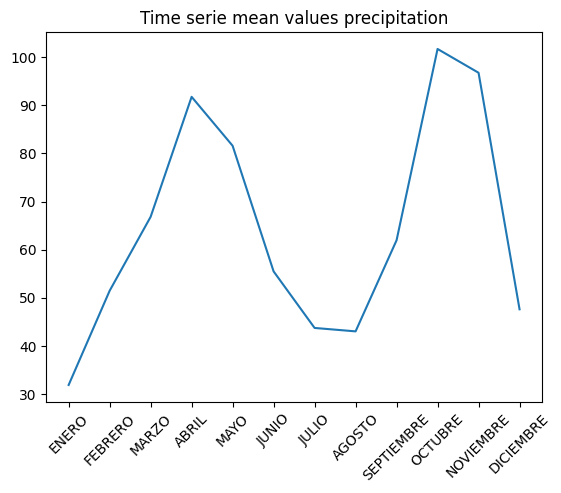

In [25]:
estacion=df_group_by_estation_mean.T.columns[0]

# grafica
plt.plot(df_group_by_estation_mean.T[estacion])
plt.xticks(rotation=45)
plt.title("Time serie mean values precipitation")

# trasponiendo para graficar
df_group_by_estation_aux=df_group_by_estation[['AÑO','ENERO', 'FEBRERO', 'MARZO', 'ABRIL', 'MAYO', 'JUNIO', 'JULIO', 'AGOSTO', 'SEPTIEMBRE', 'OCTUBRE', 'NOVIEMBRE', 'DICIEMBRE']]
df_group_by_estation_aux.index=df_group_by_estation_aux['AÑO']
df_group_by_estation_aux=df_group_by_estation_aux.drop('AÑO', axis=1)
df_group_by_estation_auxt=df_group_by_estation_aux.T

index=['9999-01-01', '9999-02-01', '9999-03-01','9999-04-01', '9999-05-01', '9999-06-01','9999-07-01', '9999-08-01', '9999-09-01','9999-10-01', '9999-11-01', '9999-12-01']
df_group_by_estation_auxt.index=index

#quitar columnas duplicadas
df_group_by_estation_auxt = df_group_by_estation_auxt.loc[:, ~df_group_by_estation_auxt.columns.duplicated()]
df_group_by_estation_auxt.columns

# orgaminzando anios en leyenda
anios=[int(i) for i in df_group_by_estation_auxt.columns]
anios.sort()
legend_order = [str(i) for i in anios]

df_group_by_estation_auxt.columns=[str(i) for i in df_group_by_estation_auxt.columns]
df_group_by_estation_auxt=df_group_by_estation_auxt[legend_order]

fig = px.line(df_group_by_estation_auxt, x=df_group_by_estation_auxt.index, y=df_group_by_estation_auxt.columns,
              category_orders={'variable': legend_order})

# creando botones para seleccionar y deseleccionar todo
# Convertir fig a una figura de go.Figure para personalización avanzada
fig = go.Figure(fig)



# Añadir botones para seleccionar y deseleccionar todo
fig.update_layout(
    updatemenus=[
        dict(type="buttons", direction="left",
            buttons=list([
                dict(
                    args=["visible", "legendonly"],  label="Deselect All", method="restyle"
                ),
                dict(
                    args=["visible", True], label="Select All", method="restyle"
                ),
            ]),
            pad={"r": 10, "t": 10},
            showactive=True,  x=0.0, xanchor="left",  y=1.1, yanchor="top"
        ),
    ]
)
fig.show()

In [26]:
#!pip install --upgrade nbformat

In [27]:
df_group_by_estation_auxt.index=['-01-01', '-02-01', '-03-01','-04-01', '-05-01', '-06-01','-07-01', '-08-01', '-09-01','-10-01', '-11-01', '-12-01']

# Convertir el DataFrame a formato largo
df_long = df_group_by_estation_auxt.reset_index().melt(id_vars='index', var_name='Year', value_name='Precipitation')
df_long.rename(columns={'index': 'Month'}, inplace=True)

df_long['Month']=[str(df_long['Year'][i])+str(df_long['Month'][i]) for i in range(len(df_long['Month']))]
df_long

,Month,Year,Precipitation
0,1955-01-01,1955,0.0
1,1955-02-01,1955,18.0
2,1955-03-01,1955,94.0
3,1955-04-01,1955,75.0
4,1955-05-01,1955,43.6
...,...,...,...
775,2019-08-01,2019,0.0
776,2019-09-01,2019,0.0
777,2019-10-01,2019,0.0
778,2019-11-01,2019,0.0


In [28]:
# Crear una columna de fecha completa (año-mes)
df_long['Date'] = pd.to_datetime(df_long['Month'], format='%Y-%m-%d')

In [29]:
# Establecer la columna de fecha como índice
df_long.set_index('Date', inplace=True)

In [30]:
# Ordenar el DataFrame por la fecha
df_long.sort_index(inplace=True)

<Axes: xlabel='Date'>

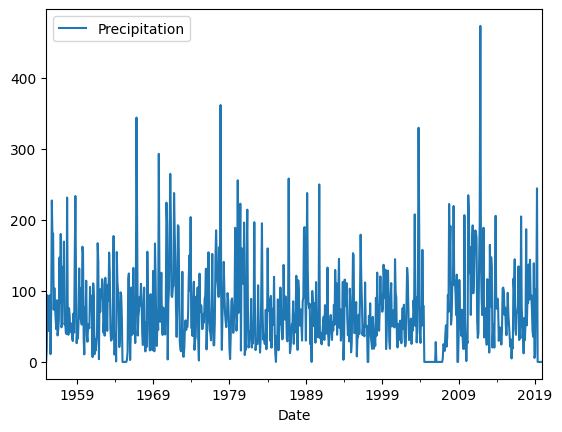

In [31]:
df_long.plot()

In [32]:
df_long=df_long[['Precipitation']]

In [33]:
df_long

,Precipitation
Date,
1955-01-01,0.0
1955-02-01,18.0
1955-03-01,94.0
1955-04-01,75.0
1955-05-01,43.6
...,...
2019-08-01,0.0
2019-09-01,0.0
2019-10-01,0.0


<Axes: xlabel='Date'>

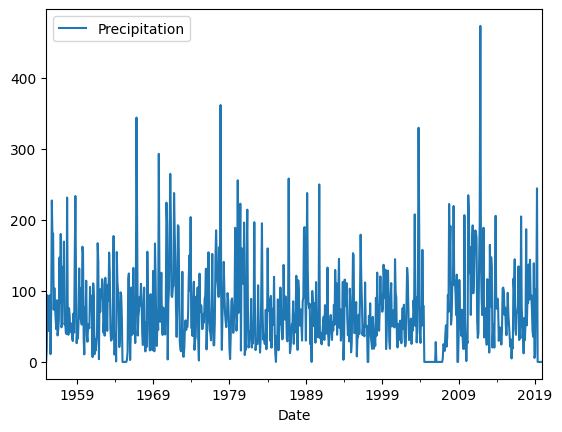

In [34]:
df_long.plot()

<Axes: xlabel='Date'>

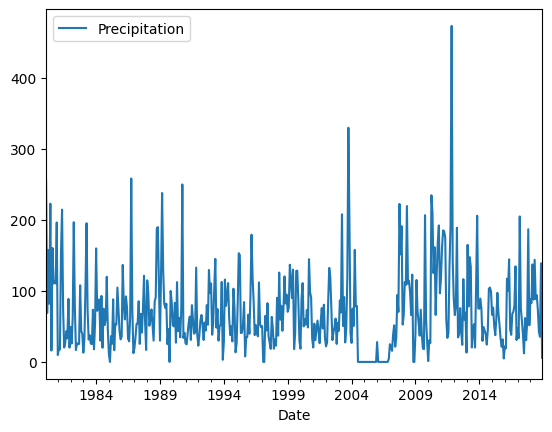

In [35]:
df_long=df_long[(df_long.index>'1980-01-01')]
df_long=df_long[(df_long.index<'2019-01-01')]
df_long.plot()

In [36]:
%%time
import pandas as pd
import matplotlib.pyplot as plt

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator


/home/stevens/.local/lib/python3.10/site-packages/gluonts/json.py:102: UserWarning:

Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.



CPU times: user 1.41 s, sys: 499 ms, total: 1.91 s
Wall time: 1.42 s


In [37]:
!python3.6 -m pip install "gluonts[torch]"

/bin/bash: line 1: python3.6: command not found


In [38]:
df_long

,Precipitation
Date,
1980-02-01,256.0
1980-03-01,69.0
1980-04-01,157.5
1980-05-01,82.0
1980-06-01,223.0
...,...
2018-08-01,74.0
2018-09-01,43.0
2018-10-01,35.4


In [39]:
#!pip install pymannkendall


Test de tendencia Mann-Kendall:
Estadístico Z: 0.37492493498770424
p-value: 0.7077162940546367
Tendencia: No hay tendencia
Nivel de significancia: False
No hay una tendencia significativa.



Análisis estadístico básico:
count    467.000000
mean      70.377944
std       57.229409
min        0.000000
25%       31.000000
50%       55.500000
75%       92.950000
max      473.500000
Name: Precipitation, dtype: float64

Valores nulos:
0

Test de normalidad (Shapiro-Wilk):
Estadístico: 0.870463965039677, p-value: 2.8429683296742867e-19
Se rechaza la hipótesis nula: la distribución no es normal.

Test de normalidad (Kolmogorov-Smirnov):
Estadístico: 0.923703635158948, p-value: 0.0
Se rechaza la hipótesis nula: la distribución no es normal.

Test de Dickey-Fuller aumentado (ADF) para estacionariedad:
Estadístico: -4.666211471707549, p-value: 9.73511579805735e-05
Valor crítico (1%): -3.444868194858831
Valor crítico (5%): -2.867941416548597
Valor crítico (10%): -2.5701797149735146
La serie es es

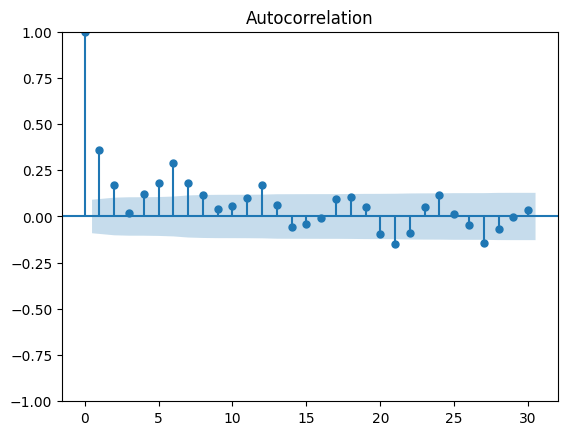


Autocorrelación parcial:


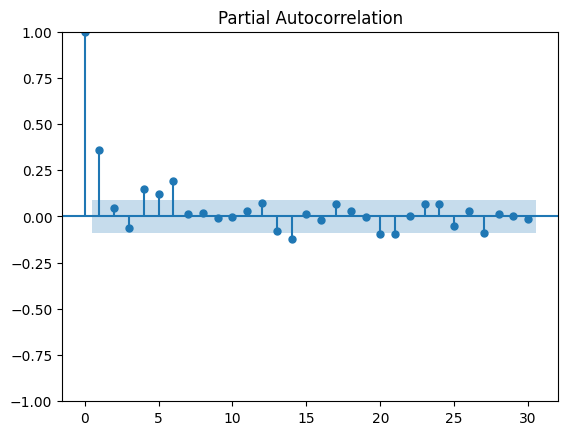

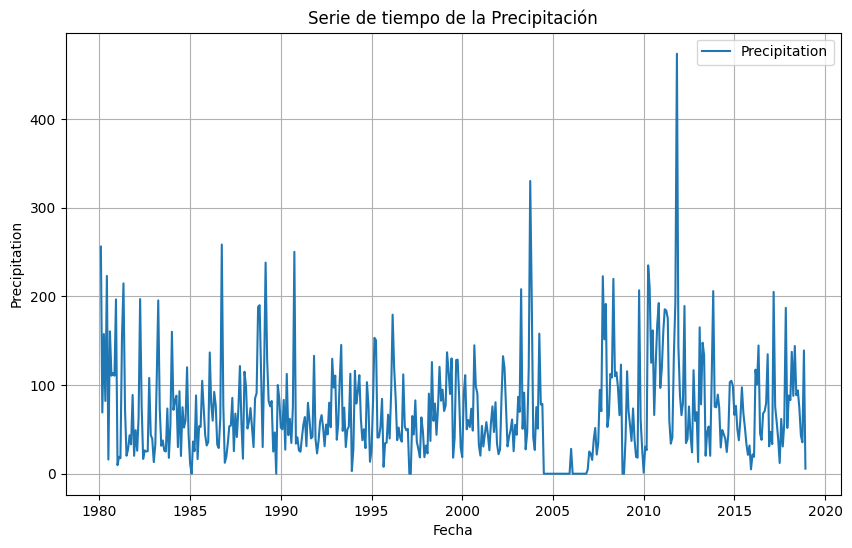

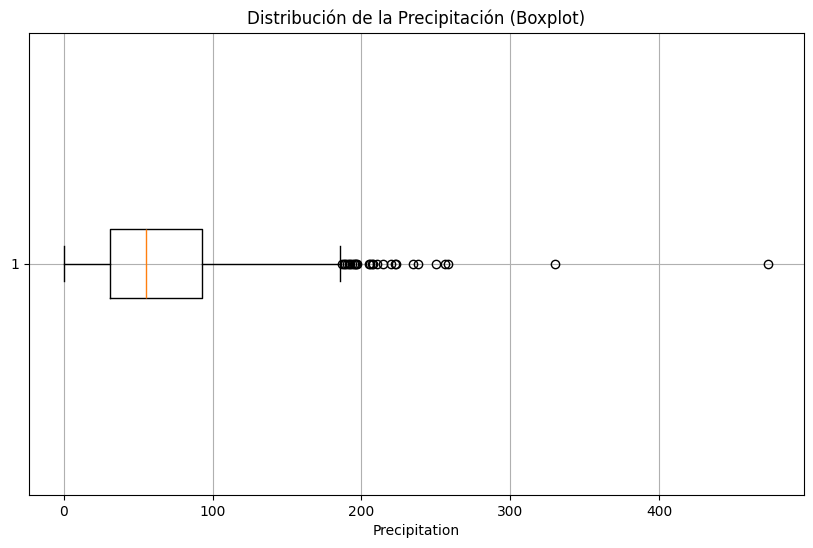

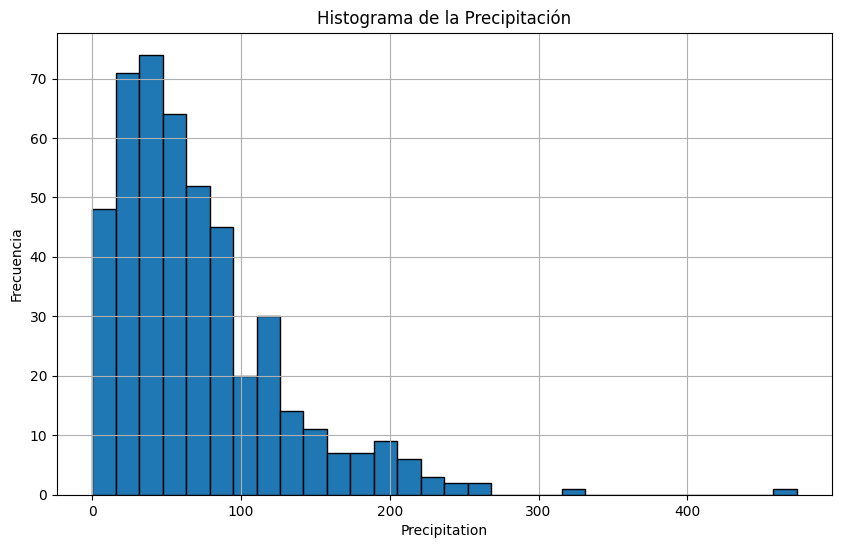

/tmp/ipykernel_9967/1331345786.py:85: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



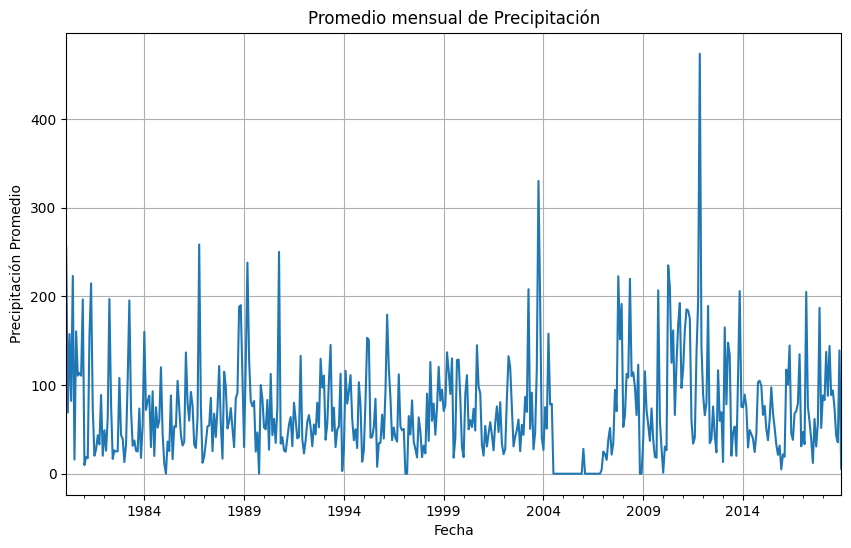

In [42]:
# Importar bibliotecas necesarias
from scipy.stats import shapiro, kstest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Función para análisis descriptivo con tests
def analisis_descriptivo_con_tests(df):
    # Asegurarse de que el índice sea de tipo fecha
    df.index = pd.to_datetime(df.index)

    # Análisis básico
    print("Análisis estadístico básico:")
    print(df['Precipitation'].describe())

    # Calcular la cantidad de valores nulos
    print("\nValores nulos:")
    print(df['Precipitation'].isnull().sum())

    # Test de normalidad (Shapiro-Wilk)
    print("\nTest de normalidad (Shapiro-Wilk):")
    stat, p_value = shapiro(df['Precipitation'].dropna())
    print(f'Estadístico: {stat}, p-value: {p_value}')
    if p_value > 0.05:
        print("No se rechaza la hipótesis nula: la distribución es aproximadamente normal.")
    else:
        print("Se rechaza la hipótesis nula: la distribución no es normal.")

    # Alternativamente, el test de Kolmogorov-Smirnov
    print("\nTest de normalidad (Kolmogorov-Smirnov):")
    stat, p_value = kstest(df['Precipitation'].dropna(), 'norm')
    print(f'Estadístico: {stat}, p-value: {p_value}')
    if p_value > 0.05:
        print("No se rechaza la hipótesis nula: la distribución es aproximadamente normal.")
    else:
        print("Se rechaza la hipótesis nula: la distribución no es normal.")

    # Test de estacionariedad (Dickey-Fuller aumentado)
    print("\nTest de Dickey-Fuller aumentado (ADF) para estacionariedad:")
    result = adfuller(df['Precipitation'].dropna())
    print(f'Estadístico: {result[0]}, p-value: {result[1]}')
    for key, value in result[4].items():
        print(f'Valor crítico ({key}): {value}')
    if result[1] < 0.05:
        print("La serie es estacionaria (se rechaza la hipótesis nula).")
    else:
        print("La serie no es estacionaria (no se rechaza la hipótesis nula).")

    # Test de autocorrelación (ACF y PACF)
    print("\nAutocorrelación:")
    plot_acf(df['Precipitation'].dropna(), lags=30)
    plt.show()

    print("\nAutocorrelación parcial:")
    plot_pacf(df['Precipitation'].dropna(), lags=30)
    plt.show()

    # Mostrar la serie temporal
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df['Precipitation'], label='Precipitation')
    plt.title('Serie de tiempo de la Precipitación')
    plt.xlabel('Fecha')
    plt.ylabel('Precipitation')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Boxplot de precipitación para ver la distribución
    plt.figure(figsize=(10, 6))
    plt.boxplot(df['Precipitation'].dropna(), vert=False)
    plt.title('Distribución de la Precipitación (Boxplot)')
    plt.xlabel('Precipitation')
    plt.grid(True)
    plt.show()

    # Histogramas para analizar la distribución
    plt.figure(figsize=(10, 6))
    plt.hist(df['Precipitation'].dropna(), bins=30, edgecolor='black')
    plt.title('Histograma de la Precipitación')
    plt.xlabel('Precipitation')
    plt.ylabel('Frecuencia')
    plt.grid(True)
    plt.show()

    # Análisis de la tendencia a lo largo del tiempo
    df['Precipitation'].resample('M').mean().plot(figsize=(10, 6), title='Promedio mensual de Precipitación', grid=True)
    plt.xlabel('Fecha')
    plt.ylabel('Precipitación Promedio')
    plt.show()



# Importar la biblioteca pyMannKendall para el test de tendencia
import pymannkendall as mk

# Función para realizar el test de tendencia de Mann-Kendall
def test_tendencia_mann_kendall(df):
    # Asegurarse de que el índice sea de tipo fecha
    df.index = pd.to_datetime(df.index)

    # Realizar el test de Mann-Kendall para la columna 'precipitacion'
    tendencia = mk.original_test(df['Precipitation'].dropna())
    
    # Mostrar resultados del test
    print("\nTest de tendencia Mann-Kendall:")
    print(f"Estadístico Z: {tendencia.z}")
    print(f"p-value: {tendencia.p}")
    print(f"Tendencia: {'Ascendente' if tendencia.trend == 'increasing' else 'Descendente' if tendencia.trend == 'decreasing' else 'No hay tendencia'}")
    print(f"Nivel de significancia: {tendencia.h}")
    
    # Interpretación de resultados
    if tendencia.h:
        print("Hay una tendencia significativa.")
    else:
        print("No hay una tendencia significativa.")


# Asumiendo que tienes un DataFrame df con el índice de fechas y la columna 'precipitacion'
test_tendencia_mann_kendall(df_long)
print("\n\n")
# Asumiendo que tienes un DataFrame df con el índice de fechas y la columna 'precipitacion'
analisis_descriptivo_con_tests(df_long)

In [41]:
#!pip install statsmodes

In [39]:
dataset = PandasDataset(df_long, target="Precipitation")

In [40]:

# Split the data for training and testing
training_data, test_gen = split(dataset, offset=-36)
test_data = test_gen.generate_instances(prediction_length=12, windows=3)

# Train the model and make predictions
model = DeepAREstimator(
    prediction_length=12, freq="M", trainer_kwargs={"max_epochs": 5, "gradient_clip_val": 30.0,}
).train(training_data)

forecasts = list(model.predict(test_data.input))



/home/stevens/.local/lib/python3.10/site-packages/gluonts/time_feature/_base.py:249: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

/home/stevens/.local/lib/python3.10/site-packages/gluonts/time_feature/lag.py:104: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/stevens/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or on

Epoch 0: |          | 50/? [00:06<00:00,  8.30it/s, v_num=0, train_loss=5.060]

Epoch 0, global step 50: 'train_loss' reached 5.05506 (best 5.05506), saving model to '/home/stevens/Documents/PORTAFOLIO/PYTHON/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1


Epoch 1: |          | 50/? [00:05<00:00,  8.63it/s, v_num=0, train_loss=4.960]

Epoch 1, global step 100: 'train_loss' reached 4.96394 (best 4.96394), saving model to '/home/stevens/Documents/PORTAFOLIO/PYTHON/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1


Epoch 2: |          | 50/? [00:02<00:00, 20.19it/s, v_num=0, train_loss=4.730]

Epoch 2, global step 150: 'train_loss' reached 4.72703 (best 4.72703), saving model to '/home/stevens/Documents/PORTAFOLIO/PYTHON/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1


Epoch 3: |          | 50/? [00:03<00:00, 13.18it/s, v_num=0, train_loss=4.490]

Epoch 3, global step 200: 'train_loss' reached 4.49054 (best 4.49054), saving model to '/home/stevens/Documents/PORTAFOLIO/PYTHON/lightning_logs/version_0/checkpoints/epoch=3-step=200.ckpt' as top 1


Epoch 4: |          | 50/? [00:02<00:00, 22.35it/s, v_num=0, train_loss=4.590]

Epoch 4, global step 250: 'train_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: |          | 50/? [00:02<00:00, 22.30it/s, v_num=0, train_loss=4.590]


/home/stevens/.local/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/stevens/.local/lib/python3.10/site-packages/g

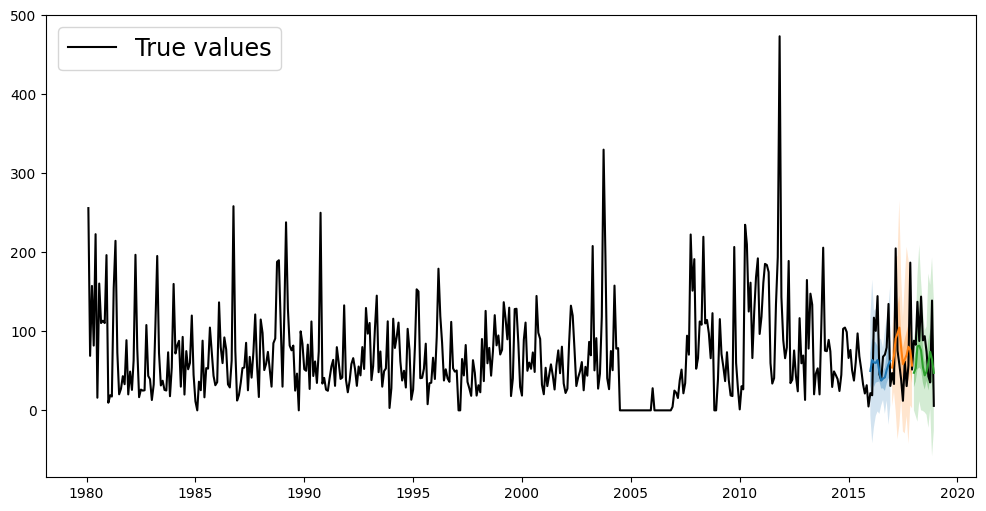

In [41]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(df_long, color="black")
#plt.figure(figsize=(2, 2))
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()

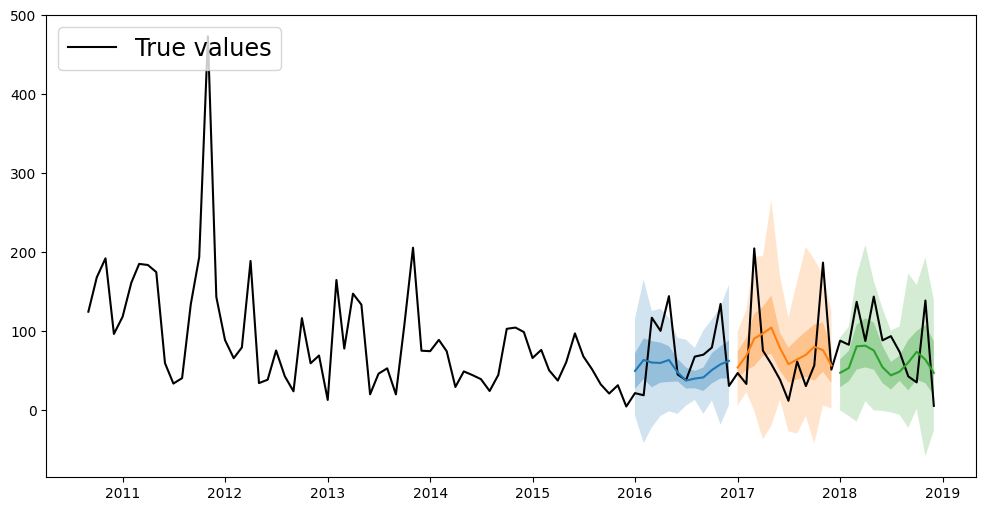

In [42]:
# Plot predictions
plt.figure(figsize=(12, 6))
plt.plot(df_long.iloc[(len(df_long)-100):len(df_long),:], color="black")
#plt.figure(figsize=(2, 2))
for forecast in forecasts:
  forecast.plot()
plt.legend(["True values"], loc="upper left", fontsize="xx-large")
plt.show()

In [43]:
#Note, the forecasts are displayed in terms of a probability distribution and the shaded areas represent the 50% and 90% prediction intervals.

In [44]:
# Obtener los valores pronosticados como una lista
forecast_values = []

for forecast in forecasts:
    forecast_values.extend(forecast.samples.mean(axis=0).tolist())

print(forecast_values)

[50.44740676879883, 62.77581024169922, 55.34212875366211, 64.32180786132812, 61.1461067199707, 47.614532470703125, 42.374366760253906, 40.9591064453125, 39.47372817993164, 53.78703689575195, 59.973201751708984, 74.11346435546875, 55.31755828857422, 69.93524932861328, 92.20721435546875, 90.75697326660156, 106.53947448730469, 79.54814147949219, 56.8067512512207, 64.42691040039062, 78.36878204345703, 77.93605041503906, 81.43636322021484, 59.597686767578125, 45.68857955932617, 52.56290054321289, 77.40518188476562, 90.50936889648438, 69.44883728027344, 60.6888313293457, 43.500362396240234, 52.475074768066406, 60.70697784423828, 73.81464385986328, 73.35991668701172, 54.418495178222656]


In [45]:
#!pip install numpy scipy scikit-learn

In [46]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Convertir las predicciones y valores reales a listas para calcular las métricas
y_true = df_long.iloc[(len(df_long)-len(forecast_values)):len(df_long),:].Precipitation
y_pred = forecast_values


# Calcular RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
print(f"RMSE: {rmse}")

# Calcular MAE
mae = mean_absolute_error(y_true, y_pred)
print(f"MAE: {mae}")

# Calcular MAPE
mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
print(f"MAPE: {mape:.2f}%")


RMSE: 48.03806951339789
MAE: 39.820340707567
MAPE: 89.16%


In [47]:
RMSE: 38.04333944728711
MAE: 29.217191139856975
MAPE: 63.46%

#Un MAPE (Mean Absolute Percentage Error) del 100% significa que, en promedio, las predicciones del modelo están tan alejadas del valor real como el propio valor real. En otras palabras, el error absoluto promedio es igual al valor real promedio, lo que indica un rendimiento muy pobre del modelo.

#Para entenderlo mejor:

#MAPE se calcula como el promedio de los errores porcentuales absolutos entre las predicciones y los valores reales.
#Si MAPE es del 100%, esto implica que el modelo está, en promedio, cometiendo errores del tamaño de los valores reales, lo que sugiere que las predicciones no son útiles.
#Por ejemplo, si el valor real es 100 y el modelo predice 200 (o 0), el error absoluto es 100. El error porcentual sería 100/100 = 1, o 100%. Si esto ocurre consistentemente, el MAPE resultante sería del 100%.

SyntaxError: invalid syntax (3519479500.py, line 3)

In [ ]:
# Detener la sesión de Spark
#spark.stop()